<a href="https://colab.research.google.com/github/shireesh-kumar/COMMA10K_Segmentation/blob/main/Comma10K_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Installation
!pip install segmentation-models-pytorch


In [12]:
#Importing the required libraries
import os
import json
import numpy as np
from PIL import Image
import cv2
import random
from tqdm import tqdm
import zipfile


import torch
import torchvision
import torch.nn as nn
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt

import time
import logging


In [3]:
#Dataset Extraction

# Path to the zip file
zip_file_path = '/content/drive/MyDrive/Dataset_Comma10k.zip'

# Destination directory
extract_to_path = '/content/'

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

In [9]:
#Dataset

class Comma10k(torch.utils.data.Dataset):
    colors = np.asarray([
        (0x00, 0xff, 0x66),  # movable
        (0x40, 0x20, 0x20),  # road
        (0x80, 0x80, 0x60),  # undrivable
        (0xcc, 0x00, 0xff),  # my car
        (0xff, 0x00, 0x00),  # lane markings
    ], dtype=np.uint8)

    def __init__(self, root, split='train', transform=None):
        self.transform = transform
        with open('/content/drive/MyDrive/comma10k.json', 'r') as json_file:
            file_names = json.load(json_file)
        if split != 'train':
            split = 'val'
        self.files = file_names[split]
        self.image_root = os.path.join(root, 'imgs')
        self.label_root = os.path.join(root, 'masks')

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        image, label = self.getdata(idx)
        if self.transform:
            image, label = self.transform(image, label)
        return image, label

    def getdata(self, idx):
        file = self.files[idx]
        image_path = os.path.join(self.image_root, file)
        label_path = os.path.join(self.label_root, file)
        image = Image.open(image_path)
        label = Image.open(label_path).convert('RGB')
        image = np.asarray(image)
        label = np.asarray(label)
        label = (label[:, :, 0].astype(np.int64) + 1) >> 6
        return image, label

    @classmethod
    def get_color(cls, label):
        return cls.colors[label]


In [7]:
#Utility Classes

class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for transform in self.transforms:
            image, target = transform(image, target)
        return image, target


class RandomHorizontalFlip:
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, image, target):
        if random.random() < self.p:
            image = np.fliplr(image)
            target = np.fliplr(target)
        return image, target


class Resize:
    def __init__(self, size):
        self.size = size

    def __call__(self, image, target):
        image = cv2.resize(image, self.size, interpolation=cv2.INTER_LANCZOS4)
        target = cv2.resize(target, self.size, interpolation=cv2.INTER_NEAREST)
        return image, target


class RandomResize:
    def __init__(self, min_size, max_size=None):
        self.min_size = min_size
        if max_size is None:
            max_size = min_size
        self.max_size = max_size

    def __call__(self, image, target):
        h, w, c = image.shape
        ratio = w / h
        hr = random.randint(self.min_size, self.max_size)
        wr = round(hr * ratio)
        size = (wr, hr)
        image = cv2.resize(image, size, interpolation=cv2.INTER_LINEAR)
        target = cv2.resize(target, size, interpolation=cv2.INTER_NEAREST)
        return image, target


class RandomCrop:
    def __init__(self, size):
        self.size = size

    def __call__(self, image, target):
        h, w, c = image.shape
        xs = random.randint(0, w - self.size)
        ys = random.randint(0, h - self.size)
        xe = xs + self.size
        ye = ys + self.size
        image = image[ys:ye, xs:xe]
        target = target[ys:ye, xs:xe]
        return image, target


class RandomResizedCrop:
    def __init__(self, size, scale=(0.5, 2.0)):
        self.size = size
        self.scale = scale

    def __call__(self, image, target):
        h, w, c = image.shape

        s = random.uniform(self.scale[0], self.scale[1])
        w_crop, h_crop = round(self.size[0] / s), round(self.size[1] / s)
        xs = random.randint(0, w - w_crop)
        ys = random.randint(0, h - h_crop)
        xe = xs + w_crop
        ye = ys + h_crop
        image = image[ys:ye, xs:xe]
        target = target[ys:ye, xs:xe]

        image = cv2.resize(image, self.size, interpolation=cv2.INTER_LINEAR)
        target = cv2.resize(target, self.size, interpolation=cv2.INTER_NEAREST)

        return image, target


class ToTensor:
    def __init__(self):
        return

    def __call__(self, image, target):
        image = image.transpose(2, 0, 1)
        image = image.astype(np.float32) / 255
        target = target.astype(np.int64)
        image = torch.from_numpy(image)
        target = torch.from_numpy(target)
        return image, target


class Normalize:
    def __init__(self, mean, std):
        self.mean = torch.FloatTensor(mean).reshape(-1, 1, 1)
        self.std = torch.FloatTensor(std).reshape(-1, 1, 1)

    def __call__(self, image, target):
        image = (image - self.mean) / self.std
        return image, target


In [ ]:
#Traning

def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True


def train(
    data_root='data/comma10k',
    learning_rate=0.0003,
    weight_decay=0,
    batch_size=4,
    epochs=30,
    num_workers=4,
    model_root = '/content/drive/MyDrive/Seg'
):

    set_seed(1234)


    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    backbone = 'efficientnet-b0'
    net = smp.Unet(backbone, classes=5)
    net = net.to(device)

    optimizer = torch.optim.AdamW(
        net.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay)

    model_path = os.path.join(model_root, 'models')
    os.makedirs(model_path, exist_ok=True)
    best_val_loss = float('inf')

    # Lists to store losses for plotting
    train_losses = []
    val_losses = []


    T_train = Compose([
        RandomResizedCrop(size=(416, 416), scale=(0.5, 1.0)),
        RandomHorizontalFlip(),
        ToTensor(),
        Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225])])

    T_val = Compose([
        Resize((640, 480)),
        ToTensor(),
        Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225])])

    train_dataset = Comma10k(data_root, 'train', T_train)
    val_dataset = Comma10k(data_root, 'val', T_val)

    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
    )
    val_loader = torch.utils.data.DataLoader(
        dataset=val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
    )

    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
      t0 = time.time()
      net.train()
      total_train_loss = 0

      for x, y in tqdm(train_loader):
          x = x.to(device)
          y = y.to(device)
          optimizer.zero_grad(set_to_none=True)
          out = net(x)
          loss = criterion(out, y)
          loss.backward()
          optimizer.step()
          total_train_loss += loss.item()

      avg_train_loss = total_train_loss / len(train_loader)
      train_losses.append(avg_train_loss)

      t0 = time.time()
      net.eval()
      total_val_loss = 0

      with torch.no_grad():
          for x, y in tqdm(val_loader):
              x = x.to(device)
              y = y.to(device)
              out = net(x)
              loss = criterion(out, y)
              total_val_loss += loss.item()

      avg_val_loss = total_val_loss / len(val_loader)
      val_losses.append(avg_val_loss)

      # Print epoch number, training loss, and validation loss
      print(f'Epoch {epoch + 1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}')

      # Save the model if it has the lowest validation loss
      if avg_val_loss < best_val_loss:
          best_val_loss = avg_val_loss
          best_model_file = os.path.join(model_path, 'best_model.pt')
          torch.save(net.state_dict(), best_model_file)
          print(f"Saved Best Model: Epoch {epoch + 1} with Val Loss: {best_val_loss}")


if __name__ == '__main__':
    train(
        data_root='/content/Dataset_Comma10k',
        epochs=30,
        batch_size=8,
        learning_rate=0.00001,
        weight_decay=0.0001,
    )

In [11]:
#Evaluation

def evaluate(
    data_root='./data/comma10k',
    model_path='./logs/comma10k/test2/models/model_050.pth',
    size=(640, 480),
    batch_size=8,
    num_workers=2,
):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    backbone = 'efficientnet-b0'
    net = smp.Unet(backbone, classes=5)

    checkpoint = torch.load(model_path)
    print("Checkpoint keys:", checkpoint.keys())  # Add this line to inspect the keys

    # Directly load the state dictionary
    net.load_state_dict(checkpoint)

    net = net.to(device)
    net = net.eval()

    T_val = Compose([
        Resize(size),
        ToTensor(),
        Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225])])

    val_dataset = Comma10k(data_root, 'val', T_val)
    val_loader = torch.utils.data.DataLoader(
        dataset=val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
    )

    pack = []
    for c in range(5):
        pack.append({
            'mask': 0,
            'pred': 0,
            'inter': 0,
            'union': 0,
        })

    criterion = nn.CrossEntropyLoss()

    losses = 0
    with torch.inference_mode():
        for x, y in tqdm(val_loader):
            x = x.to(device)
            y = y.to(device)

            out = net(x)
            loss = criterion(out, y)

            losses += loss.detach()

            mask = y
            pred = torch.argmax(out, 1)

            true = mask == pred
            for c in range(5):
                mask_c = mask == c
                pred_c = pred == c
                true_mask_c = true[mask_c]
                true_pred_c = true[pred_c]

                area_mask = len(true_mask_c)
                area_pred = len(true_pred_c)
                inter = torch.sum(true_mask_c)
                union = area_mask + area_pred - inter

                pack[c]['mask'] += area_mask
                pack[c]['pred'] += area_pred
                pack[c]['inter'] += inter
                pack[c]['union'] += union

    losses_val = losses / len(val_loader)
    print(losses_val)

    print('%8s %12s %12s %12s %12s %8s %8s %8s' %
          ('class', 'mask', 'pred', 'inter', 'union', 'acc', 'iou', 'dice'))
    acc_list = []
    iou_list = []
    dice_list = []
    for c, r in enumerate(pack):
        acc = r['inter'] / r['mask']
        iou = r['inter'] / r['union']
        dice = 2 * r['inter'] / (r['mask'] + r['pred'])
        acc_list.append(acc.cpu().numpy())
        iou_list.append(iou.cpu().numpy())
        dice_list.append(dice.cpu().numpy())
        print('%8d %12d %12d %12d %12d %8.6f %8.6f %8.6f' %
              (c, r['mask'], r['pred'], r['inter'], r['union'], acc, iou, dice))

    accuracy = np.mean(acc_list)
    miou = np.mean(iou_list)
    dice_coeff = np.mean(dice_list)

    print('acc  ->', accuracy)
    print('miou ->', miou)
    print('dice ->', dice_coeff)


if __name__ == '__main__':
    evaluate(
        data_root='/content/Dataset_Comma10k',
        model_path='/content/drive/MyDrive/Seg/models/best_model.pt',
        size=(1280, 960)
    )


Checkpoint keys: odict_keys(['encoder._conv_stem.weight', 'encoder._bn0.weight', 'encoder._bn0.bias', 'encoder._bn0.running_mean', 'encoder._bn0.running_var', 'encoder._bn0.num_batches_tracked', 'encoder._blocks.0._depthwise_conv.weight', 'encoder._blocks.0._bn1.weight', 'encoder._blocks.0._bn1.bias', 'encoder._blocks.0._bn1.running_mean', 'encoder._blocks.0._bn1.running_var', 'encoder._blocks.0._bn1.num_batches_tracked', 'encoder._blocks.0._se_reduce.weight', 'encoder._blocks.0._se_reduce.bias', 'encoder._blocks.0._se_expand.weight', 'encoder._blocks.0._se_expand.bias', 'encoder._blocks.0._project_conv.weight', 'encoder._blocks.0._bn2.weight', 'encoder._blocks.0._bn2.bias', 'encoder._blocks.0._bn2.running_mean', 'encoder._blocks.0._bn2.running_var', 'encoder._blocks.0._bn2.num_batches_tracked', 'encoder._blocks.1._expand_conv.weight', 'encoder._blocks.1._bn0.weight', 'encoder._blocks.1._bn0.bias', 'encoder._blocks.1._bn0.running_mean', 'encoder._blocks.1._bn0.running_var', 'encoder._b

100%|██████████| 123/123 [02:45<00:00,  1.35s/it]


tensor(0.1266, device='cuda:0')
   class         mask         pred        inter        union      acc      iou     dice
       0     39467764     34771505     32233989     42005280 0.816717 0.767379 0.868381
       1    231916718    242602543    221081426    253437835 0.953279 0.872330 0.931812
       2    619667639    629318356    607580520    641405475 0.980494 0.947264 0.972918
       3    302273507    288443191    285270460    305446238 0.943749 0.933947 0.965845
       4      7211972      5402005      4731833      7882144 0.656108 0.600323 0.750252
acc  -> 0.8700696
miou -> 0.8242487
dice -> 0.8978418


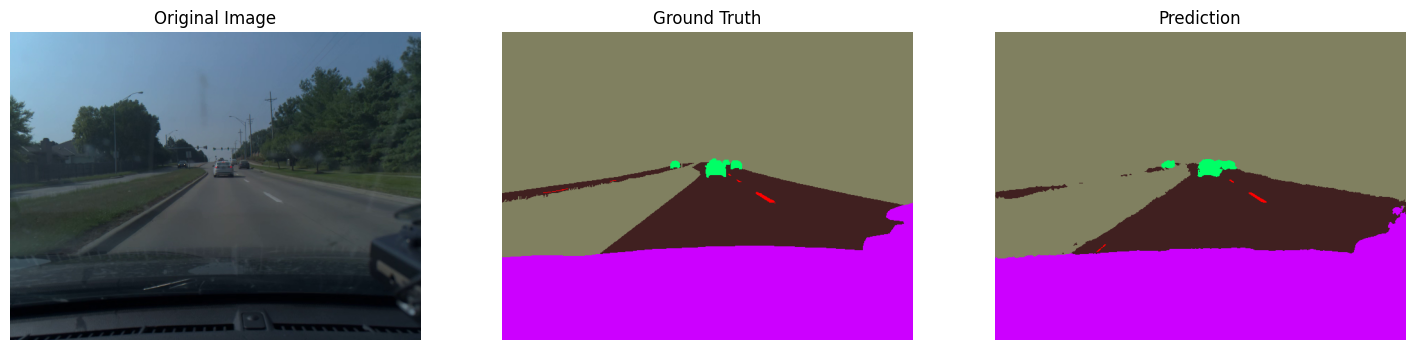

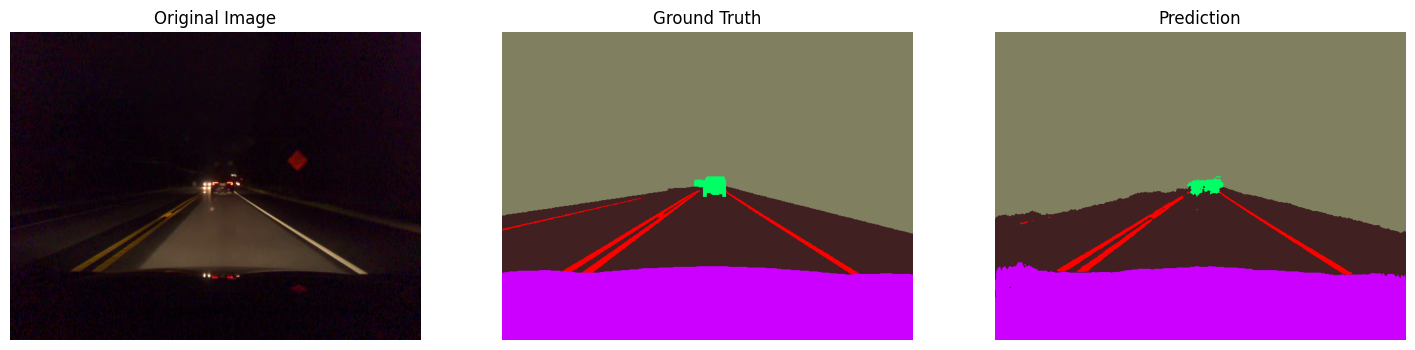

In [18]:
#Visualization

class Module:
    def __init__(self, model_path, num_classes=5):
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        backbone = 'efficientnet-b0'
        net = smp.Unet(backbone, classes=num_classes)

        checkpoint = torch.load(model_path)
        net.load_state_dict(checkpoint)
        net = net.to(device)
        net = net.eval()

        T_Compose = Compose([
            ToTensor(),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
        ])

        self.device = device
        self.net = net
        self.transform = T_Compose

    @torch.inference_mode()
    def __call__(self, image):
        x, _ = self.transform(image, image)
        x = x.unsqueeze(0).to(self.device)
        out = self.net(x)

        y = torch.argmax(out, 1)
        y = y.cpu().numpy().squeeze()

        return y

def visualize_eval(
    data_root='/content/Dataset_Comma10k',
    model_path='./logs/comma10k/test2/models/model_050.pth',
    size=(640, 480),
    indices=[0, 1, 2]
):
    module = Module(model_path)

    dataset = Comma10k(
        data_root,
        'val',
        Compose([Resize(size)])
    )

    for idx in indices:
        image, label = dataset[idx]

        y = module(image)

        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        mask = cv2.cvtColor(dataset.get_color(label), cv2.COLOR_RGB2BGR)
        pred = cv2.cvtColor(dataset.get_color(y), cv2.COLOR_RGB2BGR)


        # Plotting the results using matplotlib
        fig, ax = plt.subplots(1, 3, figsize=(18, 6))
        ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        ax[0].set_title('Original Image')
        ax[0].axis('off')
        ax[1].imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
        ax[1].set_title('Ground Truth')
        ax[1].axis('off')
        ax[2].imshow(cv2.cvtColor(pred, cv2.COLOR_BGR2RGB))
        ax[2].set_title('Prediction')
        ax[2].axis('off')
        plt.show()

if __name__ == '__main__':
    visualize_eval(
        model_path='/content/drive/MyDrive/Seg/models/best_model.pt',
        indices=[1, 2]
    )